# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [2]:
# setting basic style parameters for matplotlib
# plt.rc('figure', figsize=(13, 7))
# plt.style.use('seaborn-v0_8')

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
# basic cleaning function:
# ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

# def clean(text):
#     '''Simplified text cleaning function'''
#     stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#     text = text.lower()
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#     words = re.sub(r"[^a-z0-9\s]", '', text)
#     return [word for word in words if word not in stopwords]

### Spam Data

#### a. Load the spam data set.

In [5]:
# acquire data from spam_db

from env import username, password, host

def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url)
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Ci..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 t...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_validate, test = train_test_split(df, random_state = 1349, train_size=.8, stratify=df.label)

train, validate = train_test_split(train_validate, random_state = 1349, train_size=.7, stratify=train_validate.label)

### If we look at this in the context of a classification problem,
we may ask:
 - What leads to a spam text?
 - What leads to a ham text?
 

In [8]:
ham_df = train[train.label == 'ham']

In [9]:
ham_words = clean(' '.join(train[train.label == 'ham']['text']))

In [10]:
spam_words = clean(' '.join(train[train.label == 'spam']['text']))
all_words = clean(' '.join(train['text']))

In [11]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present
len(ham_words), len(spam_words), len(all_words)

(21681, 6815, 28496)

In [12]:
len(ham_words) + len(spam_words) == len(all_words)

True

In [13]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [14]:
ham_freq.head()

im      254
get     198
ok      158
go      148
know    142
dtype: int64

In [15]:
spam_freq.head()

call    195
free    126
text     84
ur       81
txt      76
dtype: int64

In [16]:
all_freq.head()

call    320
im      262
get     243
ur      202
4       175
dtype: int64

In [17]:
all_freqs = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
all_freqs.columns = ['ham', 'spam', 'all']

In [18]:
all_freqs.head(20)

,ham,spam,all
im,254,8,262
get,198,45,243
ok,158,3,161
go,148,20,168
know,142,16,158
dont,141,13,154
come,138,4,142
like,127,9,136
day,126,15,141
call,125,195,320


## Exploration

Represent text as word frequencies.

In [19]:
# concat all frequencies together into a dataframe

- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [20]:
all_freqs.sort_values('spam', ascending=False)

,ham,spam,all
call,125,195,320
free,31,126,157
text,43,84,127
ur,121,81,202
txt,7,76,83
...,...,...,...
cuddling,1,0,1
shijutta,1,0,1
ultimately,1,0,1
tor,1,0,1


In [21]:
all_freqs.sort_values(['ham', 'spam', 'all'], ascending=False).head()

,ham,spam,all
im,254,8,262
get,198,45,243
ok,158,3,161
go,148,20,168
know,142,16,158


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

<AxesSubplot:>

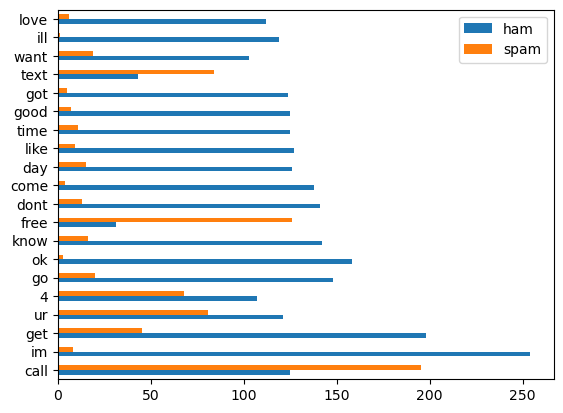

In [22]:
all_freqs.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()

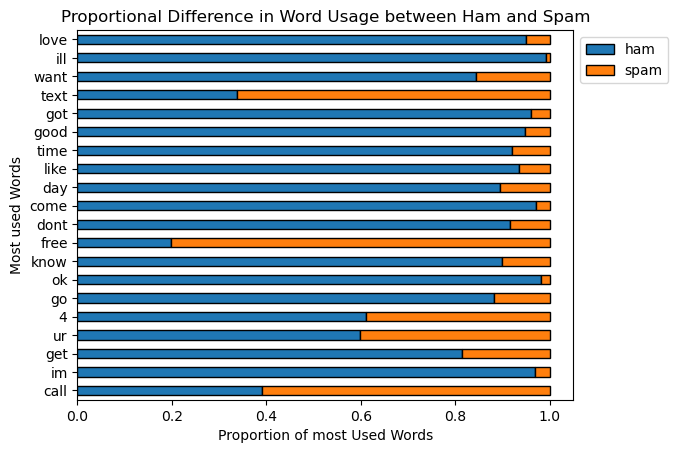

In [23]:
all_freqs.sort_values('all', ascending=False).head(20).apply(lambda row: row/row['all'], axis=1)[['ham', 'spam']]\
.plot.barh(stacked=True, ec='black')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Proportional Difference in Word Usage between Ham and Spam')
plt.xlabel('Proportion of most Used Words')
plt.ylabel('Most used Words')
plt.show()

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

**Be Careful!** Make sure you are making bigrams out of *words*.

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

In [24]:
some_string = 'here is a thing to use in our bigrams ok'

In [25]:
list(nltk.bigrams(some_string.split()))

[('here', 'is'),
 ('is', 'a'),
 ('a', 'thing'),
 ('thing', 'to'),
 ('to', 'use'),
 ('use', 'in'),
 ('in', 'our'),
 ('our', 'bigrams'),
 ('bigrams', 'ok')]

#### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [26]:
ham_words

['er',
 'hello',
 'thing',
 'didnut',
 'quite',
 'go',
 'plan',
 'uo',
 'limping',
 'slowly',
 'home',
 'followed',
 'aa',
 'exhaust',
 'hanging',
 'still',
 'around',
 'could',
 'use',
 'half8th',
 'anything',
 'lor',
 'go',
 'go',
 'lor',
 'watching',
 'tv',
 'got',
 'new',
 'job',
 'slept',
 'timeyou',
 'compliment',
 'away',
 'system',
 'side',
 'right',
 'though',
 'cant',
 'give',
 'space',
 'want',
 'need',
 'really',
 'starting',
 'become',
 'issue',
 'going',
 'suggest',
 'setting',
 'definite',
 'move',
 'outif',
 'im',
 'still',
 'greece',
 'maybe',
 'ready',
 'hi',
 'baby',
 'im',
 'cruisin',
 'girl',
 'friend',
 'give',
 'call',
 'hour',
 'home',
 'thats',
 'alright',
 'fone',
 'fone',
 'love',
 'jenny',
 'xxx',
 'yeah',
 'ill',
 'leave',
 'couple',
 'minute',
 'amp',
 'let',
 'know',
 'get',
 'mu',
 'im',
 'still',
 'looking',
 'car',
 'buy',
 'gone',
 '4the',
 'driving',
 'test',
 'yet',
 'cool',
 'let',
 'know',
 'kick',
 'around',
 'ill',
 'day',
 'babe',
 'lost',
 'tr

<AxesSubplot:>

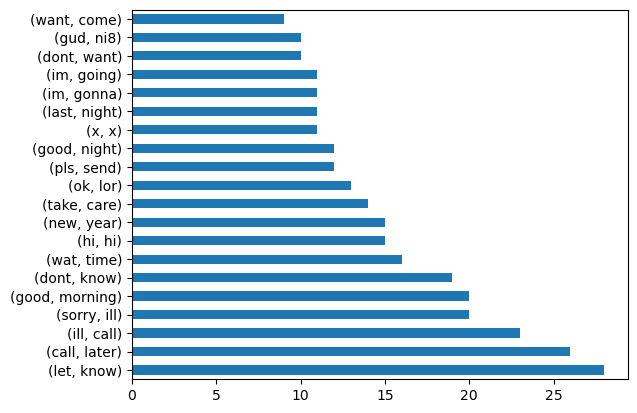

In [27]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(20).plot.barh()

<AxesSubplot:>

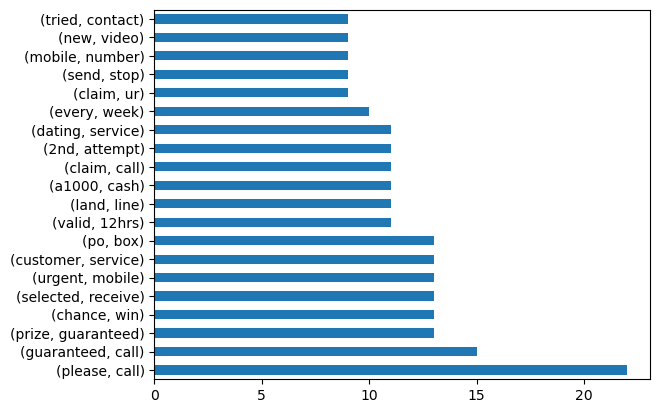

In [28]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(20).plot.barh()

#### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [60]:
(pd.Series(nltk.bigrams(ham_words))[:6814] == pd.Series(nltk.bigrams(spam_words))).sum()

0

There is no overlap between the bigrams for spam vs ham words

#### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

<AxesSubplot:>

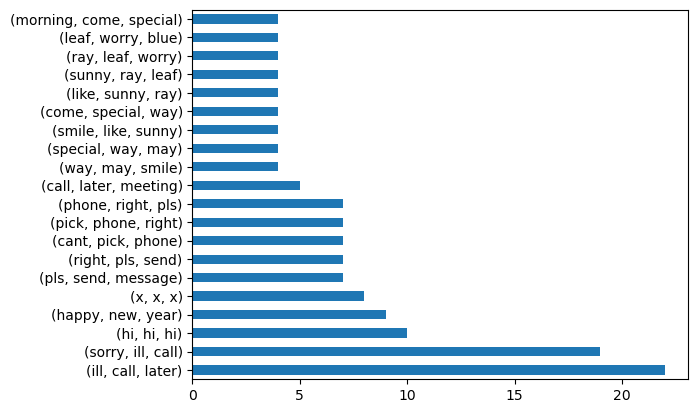

In [29]:
pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20).plot.barh()

<AxesSubplot:>

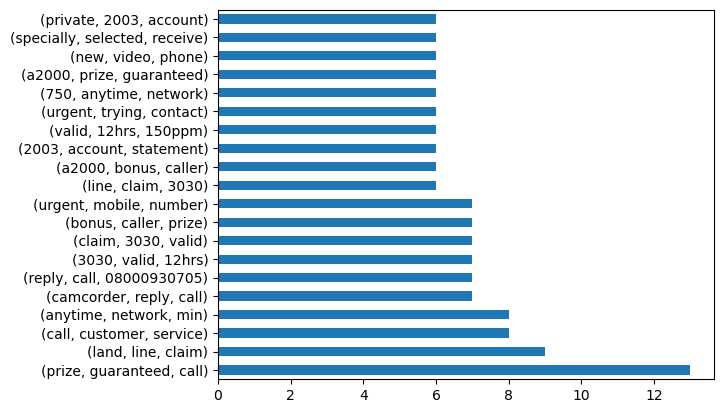

In [30]:
pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20).plot.barh()

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

In [31]:
from wordcloud import WordCloud

In [32]:
# WordCloud expects a single string

img = WordCloud(background_color='White', ).generate(' '.join(ham_words))

In [33]:
img

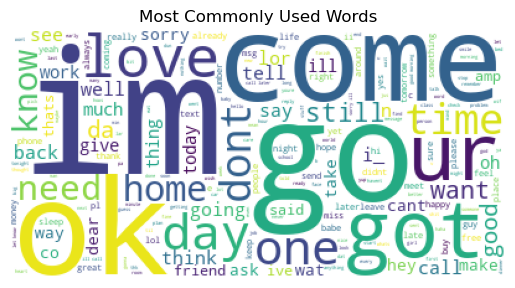

In [34]:
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Words')
plt.show()

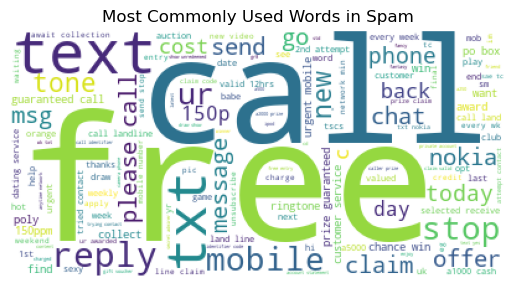

In [35]:
img = WordCloud(background_color='White', ).generate(' '.join(spam_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Words in Spam')
plt.show()

In [36]:
bigrams = [thing[0] + '_' + thing[1] for thing in nltk.bigrams(ham_words)]

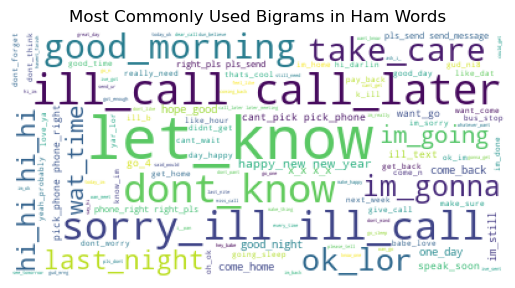

In [61]:
img = WordCloud(background_color='White', ).generate(' '.join(bigrams))
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Bigrams in Ham Words')
plt.show()

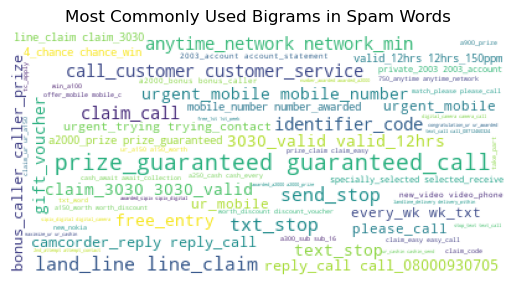

In [62]:
bigrams = [thing[0] + '_' + thing[1] for thing in nltk.bigrams(spam_words)]
img = WordCloud(background_color='White', ).generate(' '.join(bigrams))
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Bigrams in Spam Words')
plt.show()

The bigrams for the spam words seem to include a lot about phone calls, texting, and talk about time hacks with apparent few bigrams used obviously more than others, while the ham word bigrams seem to contain blatant more heavily used words which include topics like letting another person know something or telling them that they will them someone else know something, as well as greetings such as good morning and good night amd hi.

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [38]:
# we apply our clean function, apply len chained on it
# if we did not want to clean this before
# word count, we would want to do a split on it


## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [39]:
import nltk.sentiment

In [40]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [41]:
sia.polarity_scores('Things are going really really great!')

{'neg': 0.0, 'neu': 0.502, 'pos': 0.498, 'compound': 0.7152}

In [42]:
sia.polarity_scores('Everything sucks!')

{'neg': 0.736, 'neu': 0.264, 'pos': 0.0, 'compound': -0.4199}

In [43]:
sia.polarity_scores('😍')

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [44]:
train['compound_sentiment'] = train['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [45]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score


In [46]:
# is the mean and median values of sentiment score different for ham vs spam?
train.groupby('label')['compound_sentiment'].mean()

label
ham     0.148131
spam    0.454145
Name: compound_sentiment, dtype: float64

In [47]:
#plot message_length vs sentiment and hue by label


### Takeaways:
 - Spam messages seem to have roughly the same message length, where ham varies a lot.
 - Spam messages have a very positive sentiment
 - If we wanted to utilize these features for modeling, we would want to proceed forward with means testing to establish their viability

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [64]:
from prepare import prepare_news_df, prepare_codeup_df 

In [161]:
blog = prepare_codeup_df()

In [135]:
blog

,title,original,clean,stemmed,lemmatized
0,Women in tech: Panelist Spotlight – Magdalena Rahn,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 2...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...
1,Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 2...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...
2,Women in Tech: Panelist Spotlight – Sarah Mellor,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March ...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...
3,Women in Tech: Panelist Spotlight – Madeleine Capper,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 2...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...
4,Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia,\n\nCodeup is hosting a Black Excellence in Tech Panel in honor of Black History Month...,codeup hosting black excellence tech panel honor black history month february 22 2023 ...,codeup host black excel tech panel honor black histori month februari 22 2023 celebr w...,codeup host black excel tech panel honor black histori month februari 22 2023 celebr w...
5,Black excellence in tech: Panelist Spotlight – Stephanie Jones,\nCodeup is hosting our second Black Excellence in Tech Panel in honor of Black Histor...,codeup hosting second black excellence tech panel honor black history month february 2...,codeup host second black excel tech panel honor black histori month februari 22 2023 c...,codeup host second black excel tech panel honor black histori month februari 22 2023 c...


In [163]:
def split(some_string):
    some_string = some_string.split()
    return some_string

In [164]:
count = 0
blog_list = blog['lemmatized'].apply(split)
blog_1 = blog_list[0]
blog_2 = blog_list[1]
blog_3 = blog_list[2]
blog_4 = blog_list[3]
blog_5 = blog_list[4]
blog_6 = blog_list[5]

In [169]:
words_1 = pd.Series(blog_1)
words_2 = pd.Series(blog_2)
words_3 = pd.Series(blog_3)
words_4 = pd.Series(blog_4)
words_5 = pd.Series(blog_5)
words_6 = pd.Series(blog_6)

In [198]:
all_words = pd.concat([words_1, words_2, words_3, words_4, words_5, words_6], axis=0)

In [227]:
type(all_words)

pandas.core.series.Series

In [200]:
freq_1 = pd.Series(words_1).value_counts()
freq_2 = pd.Series(words_2).value_counts()
freq_3 = pd.Series(words_3).value_counts()
freq_4 = pd.Series(words_4).value_counts()
freq_5 = pd.Series(words_5).value_counts()
freq_6 = pd.Series(words_6).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [202]:
word_counts = pd.concat([freq_1, freq_2, freq_3, freq_4, freq_5, freq_6, all_freq], axis=1
                       ).fillna(0).astype(int)
word_counts.columns = ['freq_1', 'freq_2', 'freq_3', 'freq_4', 'freq_5', 'freq_6', 'all_freq']

In [203]:
word_counts.head()

,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,all_freq
codeup,5,6,5,5,4,4,29
magdalena,5,0,0,0,0,0,5
woman,3,3,3,3,0,0,12
scienc,3,9,0,2,0,1,15
data,3,8,0,6,0,1,18


freq_1


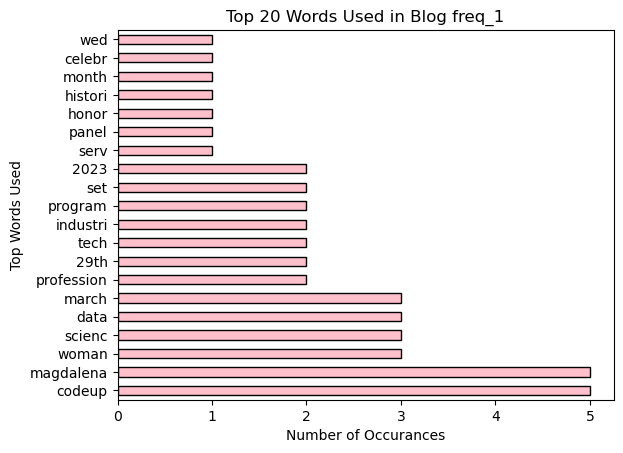

freq_2


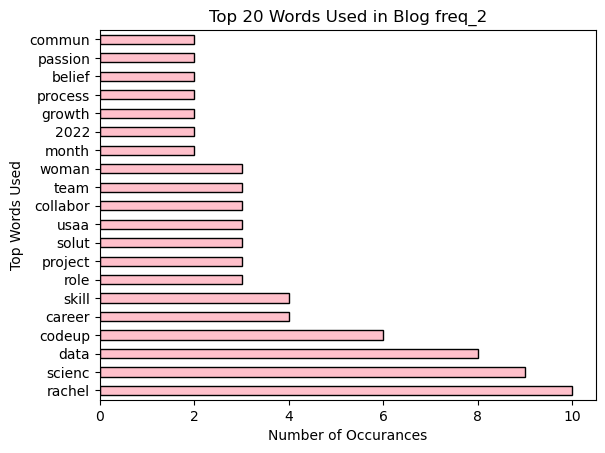

freq_3


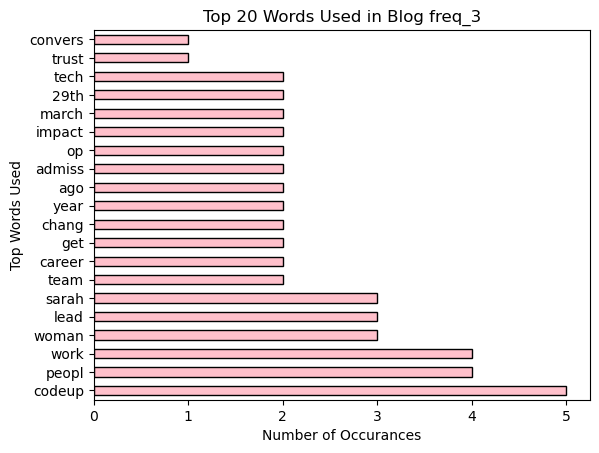

freq_4


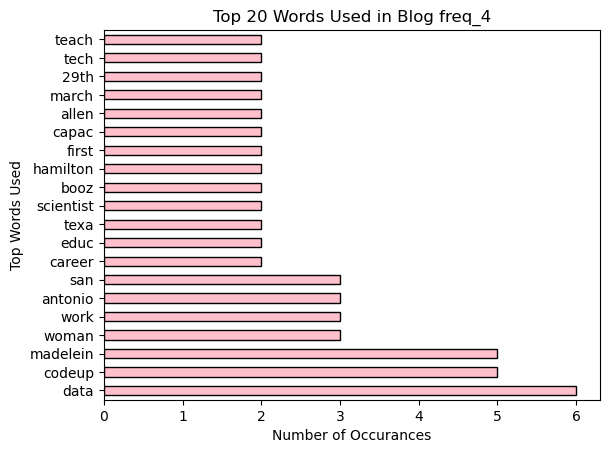

freq_5


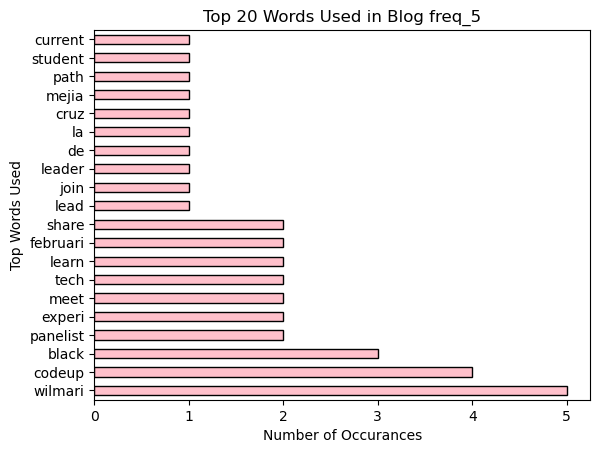

freq_6


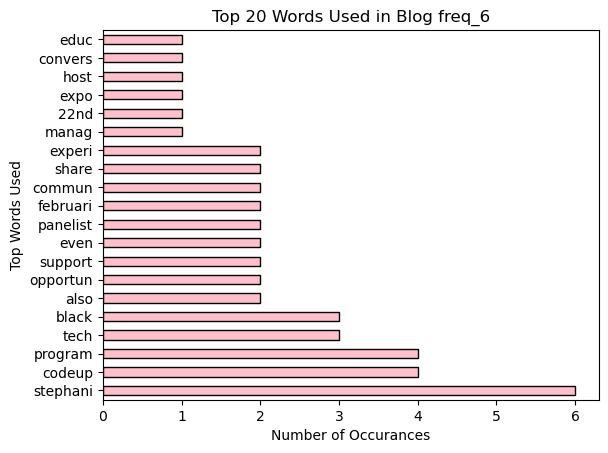

all_freq


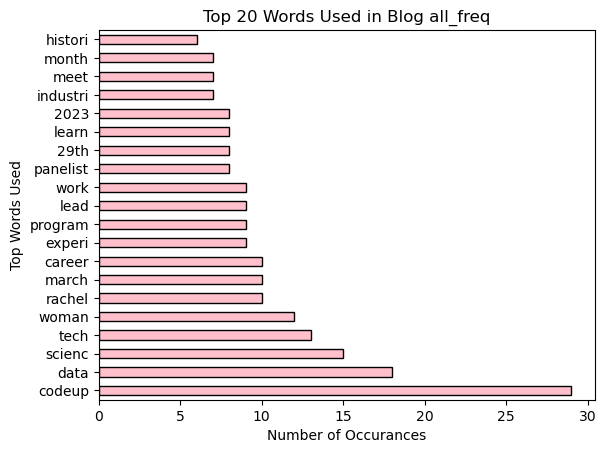

In [204]:
for col in word_counts.columns:
    print(col)
    word_counts[col].sort_values(ascending=False).head(20).plot.barh(ec='black', color='pink')
    plt.title(f'Top 20 Words Used in Blog {col}')
    plt.xlabel('Number of Occurances')
    plt.ylabel('Top Words Used')
    plt.show()

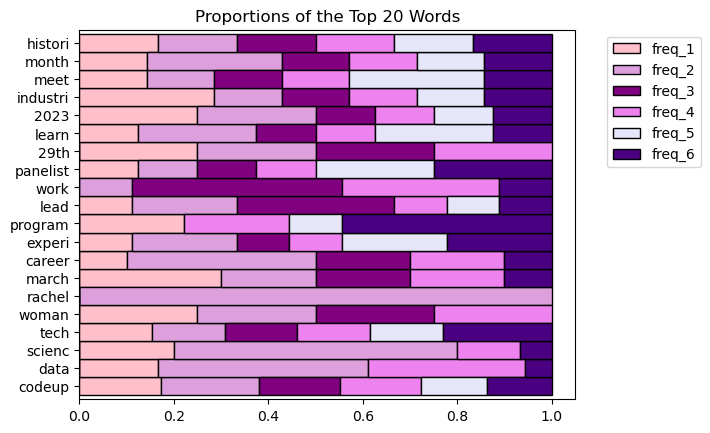

In [215]:
colors = ['pink', 'plum', 'purple', 'violet', 'lavender', 'indigo']
word_counts.sort_values('all_freq', ascending=False
                       ).head(20).apply(
    lambda row: row/row['all_freq'], axis=1
)[['freq_1', 'freq_2', 'freq_3', 'freq_4', 'freq_5', 'freq_6']].plot.barh(
    stacked=True, legend=False, ec='black', 
    width=1, color=colors).set(title='Proportions of the Top 20 Words')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
                                                         

In [252]:
words_list = [words_1, words_2, words_3, words_4, words_5, words_6, all_words]

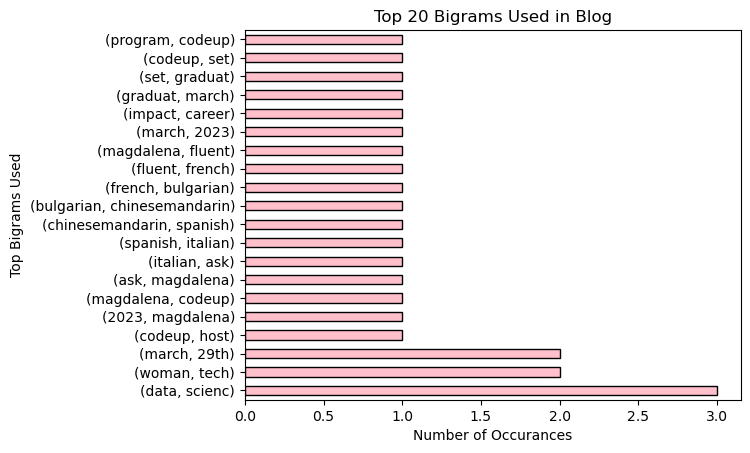

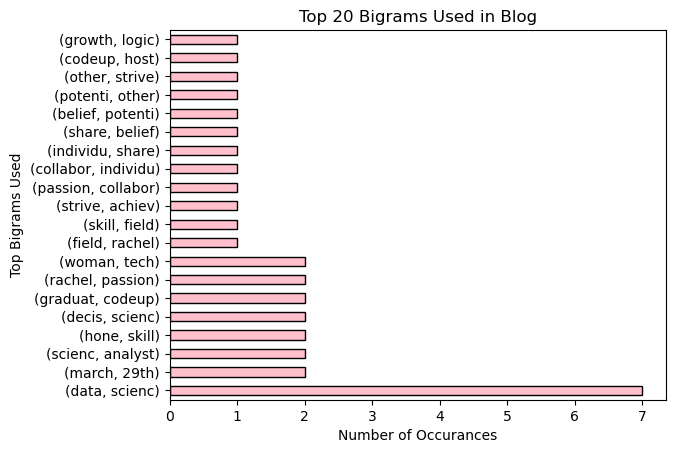

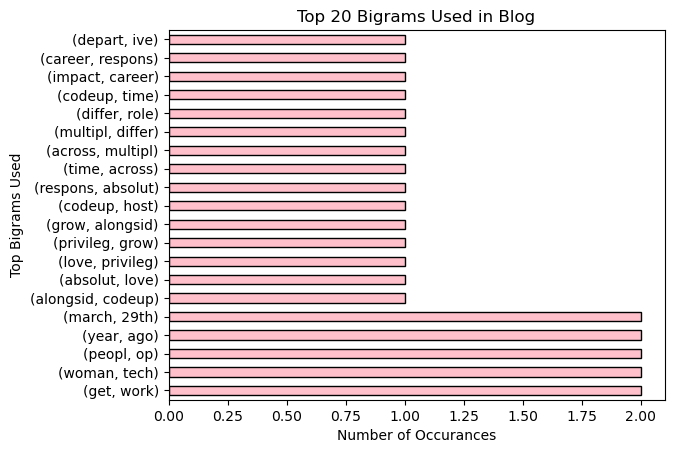

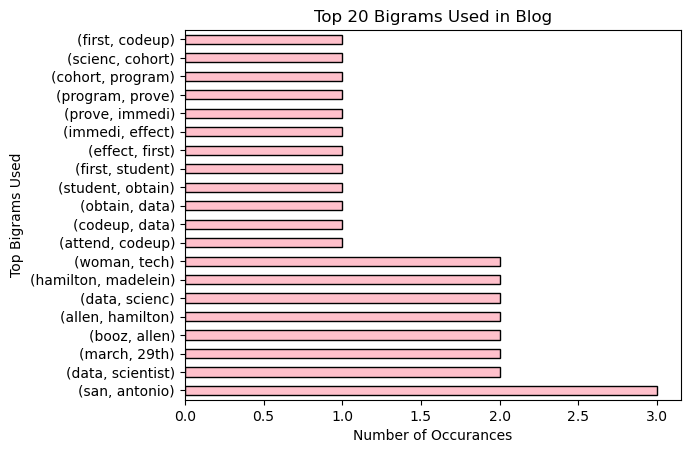

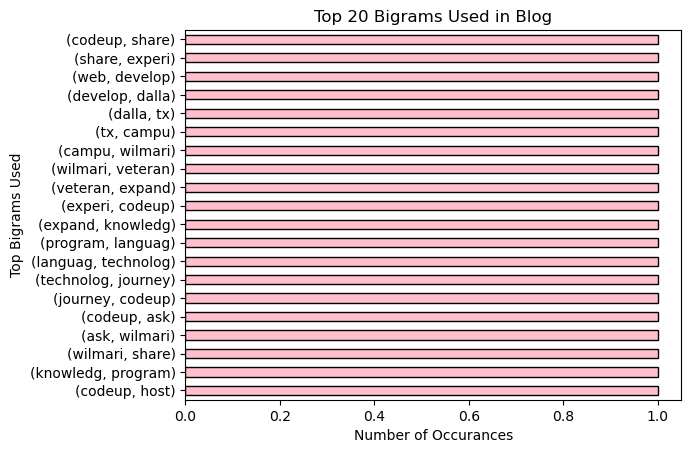

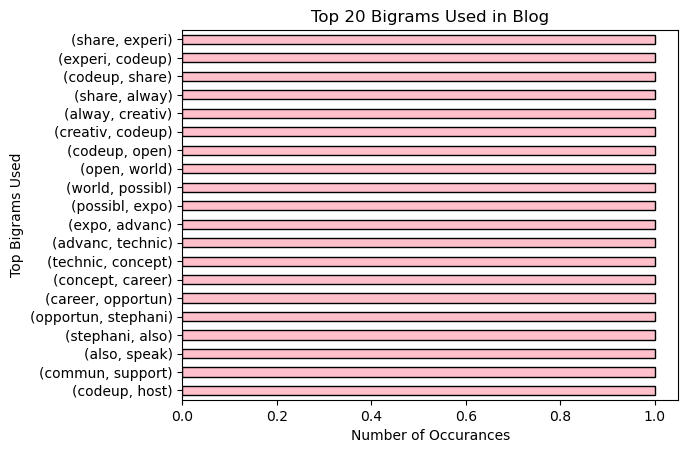

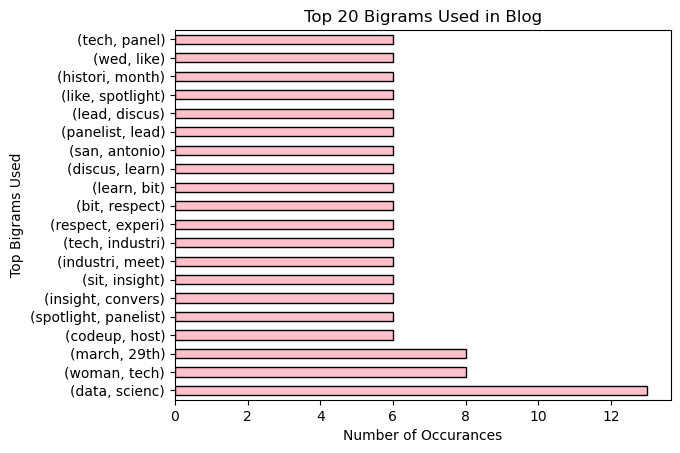

In [253]:
for series in words_list:
    pd.Series(nltk.bigrams(series)).value_counts().head(20).plot.barh(ec='black', color='pink')
    plt.title(f'Top 20 Bigrams Used in Blog')
    plt.xlabel('Number of Occurances')
    plt.ylabel('Top Bigrams Used')
    plt.show()

In [254]:
# We see that overall, the top bigrams used in these 6 blogs is data science, 
# followed by women tech

# Two of the blogs do not have use more than one bigram

### Tri-grams

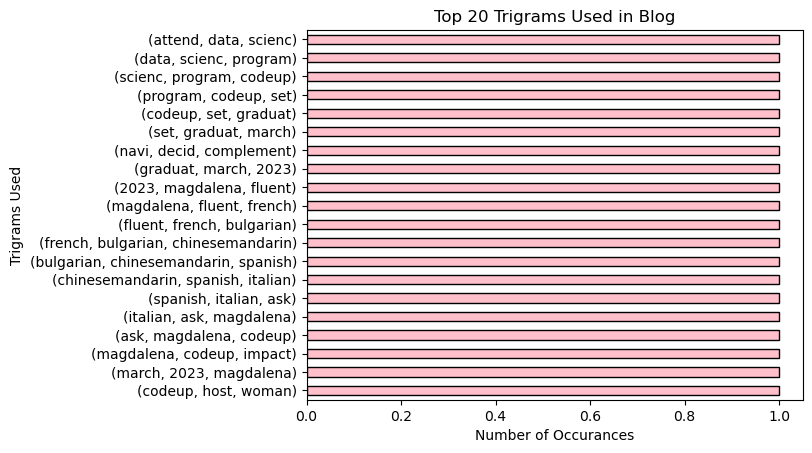

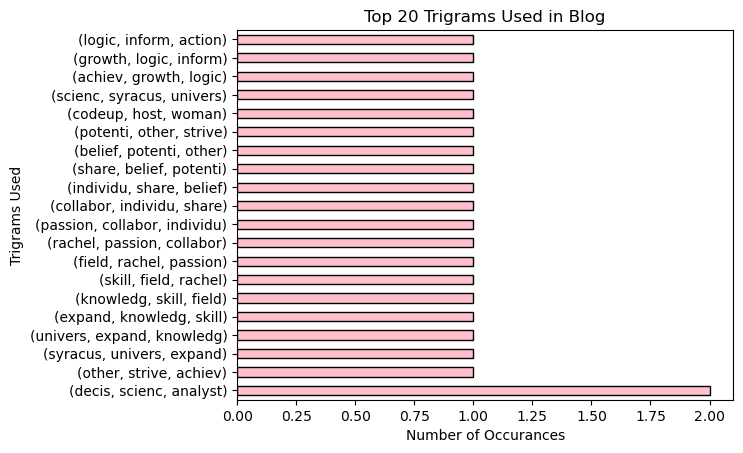

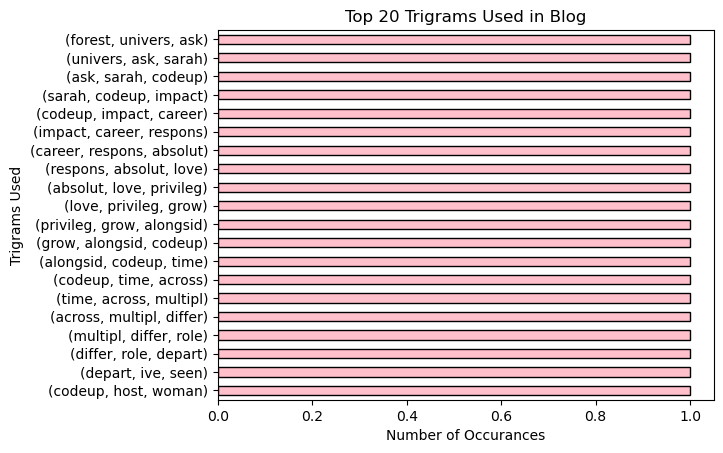

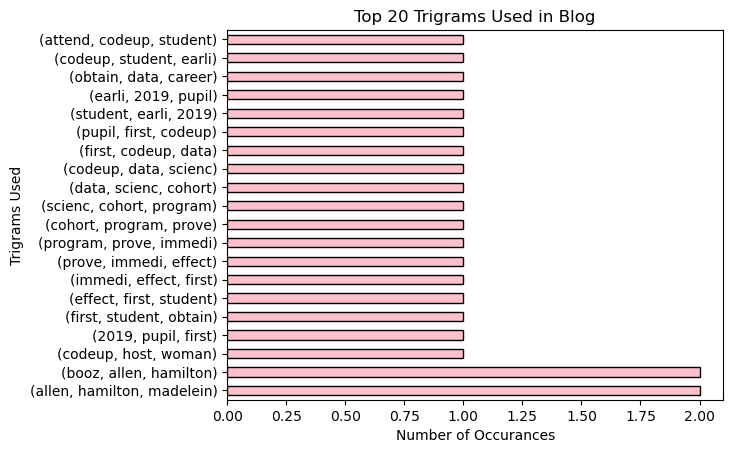

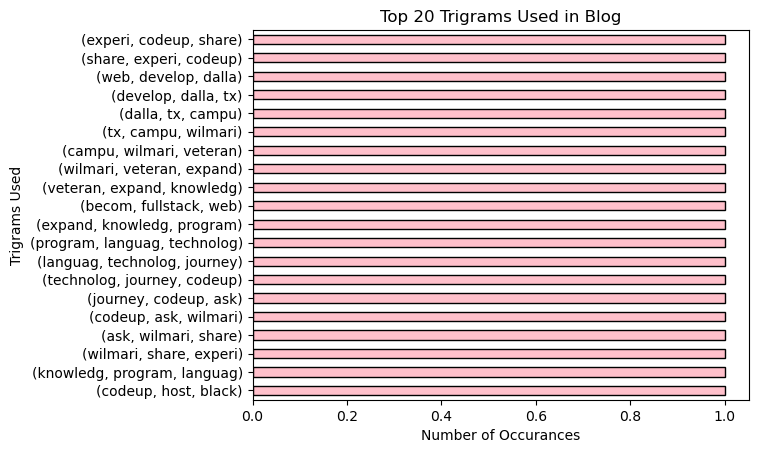

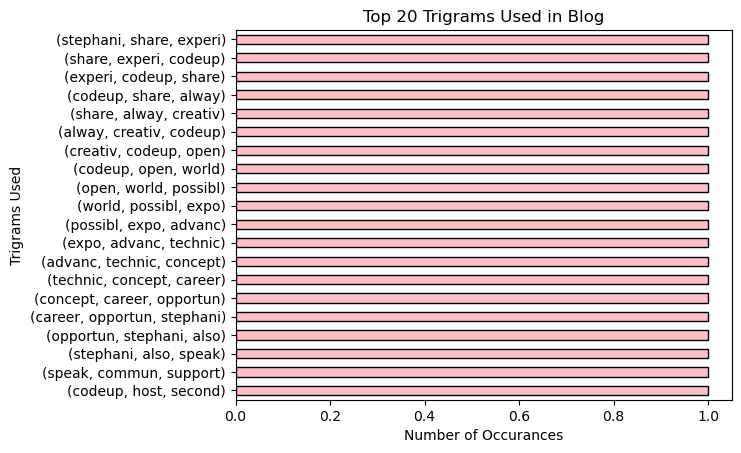

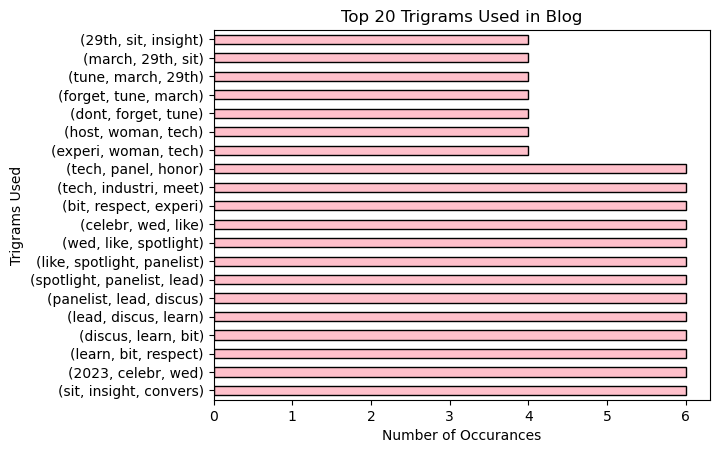

In [255]:
for series in words_list:
    pd.Series(nltk.ngrams(series, 3)).value_counts().head(20).plot.barh(ec='black', color='pink')
    plt.title(f'Top 20 Trigrams Used in Blog')
    plt.xlabel('Number of Occurances')
    plt.ylabel('Trigrams Used')
    plt.show()

In [256]:
# Overall the trigrams dont point out anything too significant. We see data science 
# analyst in blog 2 used twice. None of these have a significant number of usage more 
# than others.

### Word Clouds

In [ ]:
from wordcloud import WordCloud

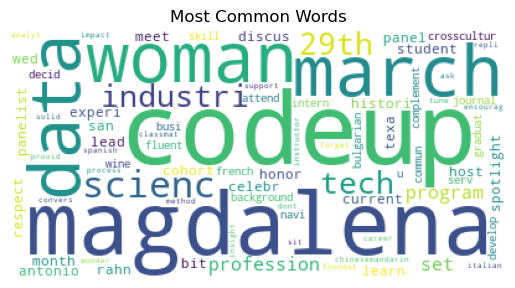

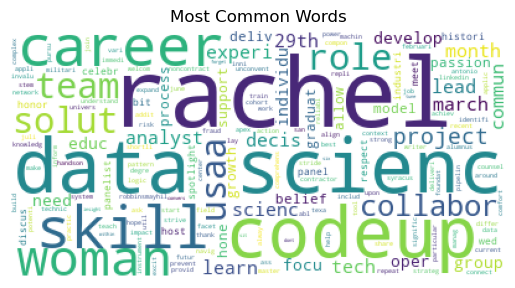

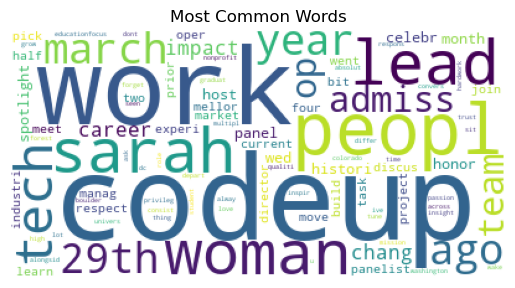

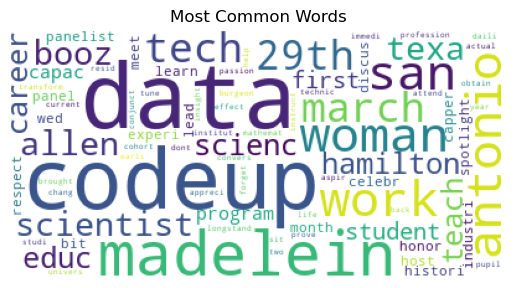

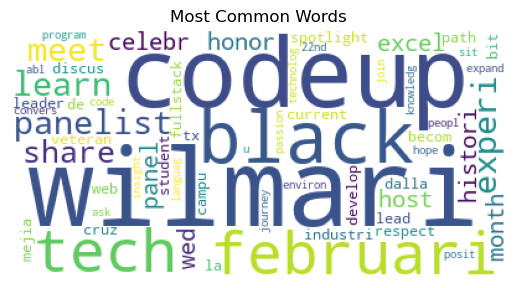

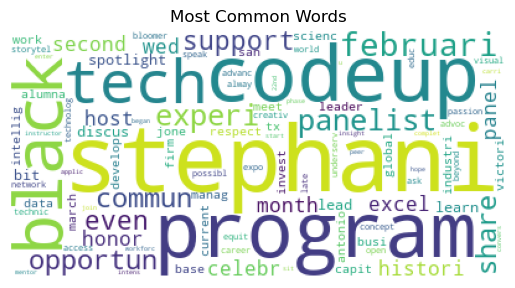

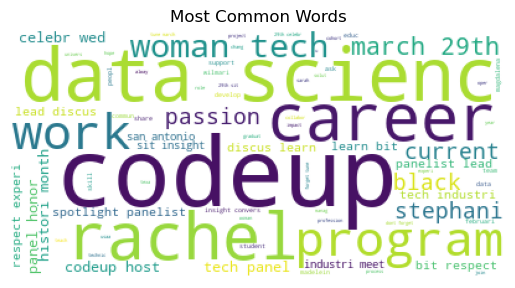

In [258]:
# wordcloud expects a single string
for series in words_list:
    img = WordCloud(background_color='White',
         ).generate(' '.join(series))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Most Common Words')
    plt.show()

In [259]:
import nltk.sentiment

In [ ]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

0    [codeup, host, woman, tech, panel, honor, woman, histori, month, march, 29th, 2023, ce...
1    [codeup, host, woman, tech, panel, honor, woman, histori, month, march, 29th, 2023, ce...
2    [codeup, host, woman, tech, panel, honor, woman, histori, month, march, 29th, 2023, ce...
3    [codeup, host, woman, tech, panel, honor, woman, histori, month, march, 29th, 2023, ce...
4    [codeup, host, black, excel, tech, panel, honor, black, histori, month, februari, 22, ...
5    [codeup, host, second, black, excel, tech, panel, honor, black, histori, month, februa...
Name: lemmatized, dtype: object

In [264]:
blog['compound_sentiment'] = blog['lemmatized'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [265]:
blog

,title,original,clean,stemmed,lemmatized,compound_sentiment
0,Women in tech: Panelist Spotlight – Magdalena Rahn,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 2...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...,0.9147
1,Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 2...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...,0.9908
2,Women in Tech: Panelist Spotlight – Sarah Mellor,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March ...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...,0.9689
3,Women in Tech: Panelist Spotlight – Madeleine Capper,\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 2...,codeup hosting women tech panel honor womens history month march 29th 2023 celebrate w...,codeup host women tech panel honor women histori month march 29th 2023 celebr wed like...,codeup host woman tech panel honor woman histori month march 29th 2023 celebr wed like...,0.9345
4,Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia,\n\nCodeup is hosting a Black Excellence in Tech Panel in honor of Black History Month...,codeup hosting black excellence tech panel honor black history month february 22 2023 ...,codeup host black excel tech panel honor black histori month februari 22 2023 celebr w...,codeup host black excel tech panel honor black histori month februari 22 2023 celebr w...,0.9779
5,Black excellence in tech: Panelist Spotlight – Stephanie Jones,\nCodeup is hosting our second Black Excellence in Tech Panel in honor of Black Histor...,codeup hosting second black excellence tech panel honor black history month february 2...,codeup host second black excel tech panel honor black histori month februari 22 2023 c...,codeup host second black excel tech panel honor black histori month februari 22 2023 c...,0.9821


In [ ]:
# Overall, eachb blog has a very high sentiment score!